In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [3]:
# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
base_epochs = 50
extra_epochs = 1
index = 1
k = 5

# RGB-HSV Dataset
rgb_train = generate_rgb_samples(1000, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(250, device=device, seed=42)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=64, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=64, shuffle=False)

# Training Base Model:
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(rgb_losses[-1:])

# Training one more Epoch
rgb_model_v2 = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model_v2.parameters(), lr=0.001)
rgb_losses_v2, trained_rgb_v2 = train_model(rgb_model_v2, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs+extra_epochs, seed=17, verbose=False, continue_training=False)
print(rgb_losses_v2[-1:])

rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv') # Full Network capture
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index) # Single Sample capture

indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=k, metric='cosine') # Finding KNN - Cosine
filtered_rgb_loader, filtered_size = create_filtered_dataloader(rgb_train_loader, exclude_indices=indices_rgb, batch_size=64, shuffle=False)
print(f"KNN Indices (Cosine): {indices_rgb}")
print(f"KNN Distances (Cosine): {distances_rgb}")

# Train a new clean model
filtered_rgb_model = RGBtoHSVNet()
rgb_optimizer_filter = optim.Adam(filtered_rgb_model.parameters(), lr=0.0001)
rgb_losses_filtered, filtered_rgb = train_model(filtered_rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)
print(rgb_losses_filtered[-1:])

# Extra Epoch with filtered data
rgb_losses_filtered_v2, filtered_rgb_v2 = train_model(filtered_rgb_model, filtered_rgb_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(rgb_losses_filtered_v2[-1:])

All seeds set to: 42
Model weights initialized with seed: 42
[0.003919601222150959]
All seeds set to: 17
Model weights initialized with seed: 17
[0.004885639013082255]
KNN Indices (Cosine): tensor([  1, 524, 685, 525, 867])
KNN Distances (Cosine): tensor([1.1921e-07, 1.9937e-03, 3.3584e-03, 8.2418e-03, 8.8762e-03])
All seeds set to: 42
Model weights initialized with seed: 42
[0.022715660044923425]
[0.022079902701079845]


In [5]:
len(rgb_activations)

1000

In [6]:
# Base model prediction
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# v2 model prediction
predictions_v2_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb_v2, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# Filtered Model prediction
predictions_filtered_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(filtered_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# base_mse = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item()
print(f"Base MSE:       {nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item():.8f}")
print(f"V2 MSE:         {nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")
print(f"Filtered MSE:   {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item():.8f}")
print(f"Verschlechterung: {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item() - nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.644, 0.851, 0.472)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.604, 0.815, 0.471)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.48

In [7]:
# Function to calculate MSE loss for different k and indices
def continue_calculate_mse_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, metric='l2'):
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    # New: store k-NN distances per subset / k / sample
    knn_distances = {
        'closest_distances': {},
        'last_distances': {},
        'random_distances': {}
    }

    for k in list_of_k:
        print(f"\n\n______Processing k={k}______\n\n")
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        knn_distances['closest_distances'][k] = []
        knn_distances['last_distances'][k] = []
        knn_distances['random_distances'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Find k-nearest neighbors for the entire dataset (return full ordering + distances)
            indices_knn, distances = find_knn(rgb_activations, single_activations, k=len(rgb_activations), metric=metric)

            # Map idx -> distance for lookup (ensure ints)
            dist_map = {int(idx): float(d) for idx, d in zip(indices_knn, distances)}

            # Closest k neighbors and their distances
            closest_indices = indices_knn[:k]
            closest_dists = [float(d) for d in distances[:k]]

            # Last k neighbors and their distances
            last_indices = indices_knn[-k:]
            last_dists = [float(d) for d in distances[-k:]]

            # Random k neighbors (sampled from the ordering) and their distances
            random_indices = np.random.choice(indices_knn, k, replace=False)
            random_dists = [dist_map[int(i)] for i in random_indices]

            for subset_name, subset_indices, subset_dists in zip(
                    ['closest_mse', 'last_mse', 'random_mse'],
                    [closest_indices, last_indices, random_indices],
                    [closest_dists, last_dists, random_dists]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Train a new model to the same point as the base epochs
                new_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(new_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()
                train_model(new_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Train the new model for one more epoch with the filtered dataset
                train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)

                # Predict and calculate MSE loss
                predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                mse_loss = nn.MSELoss()(predictions, targets).item()
                mse_results[subset_name][k].append(mse_loss)

                # store the corresponding k distances (as list of floats)
                dist_key = subset_name.replace('_mse', '_distances')
                knn_distances[dist_key][k].append(list(map(float, subset_dists)))

    return mse_results, knn_distances

In [8]:
list_of_k = list(range(0, 101, 25))
list_of_k[0] = 1

list_of_indices = list(range(1, 50, 1))
random_indices = random.sample(list_of_indices, k=15)

print(f"List of K: {list_of_k}")
print(f"Random Indices: {random_indices}")

List of K: [1, 25, 50, 75, 100]
Random Indices: [41, 8, 2, 18, 16, 15, 9, 7, 35, 6, 38, 28, 3, 47, 40]


In [9]:
# Example usage of the loop and visualization
mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l1')

# Save random_indices to a file
with open('continue_data/l1/50_epochs_15_indices.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save mse_results to a file
with open('continue_data/l1/50_epochs_15_data.pkl', 'wb') as f:
    pickle.dump(mse_results, f)
    
# Save knn_distances to a file
with open('continue_data/l1/knn_distances_50_epochs_15.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.827, 0.740, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.829, 0.739, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
----------------------------------------------------------------

In [10]:
# Example usage of the loop and visualization
mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='l2')

# Save random_indices to a file
with open('continue_data/l2/50_epochs_15_indices.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save mse_results to a file
with open('continue_data/l2/50_epochs_15_data.pkl', 'wb') as f:
    pickle.dump(mse_results, f)
    
# Save knn_distances to a file
with open('continue_data/l2/knn_distances_50_epochs_15.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.827, 0.740, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.829, 0.739, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
----------------------------------------------------------------

In [11]:
# Example usage of the loop and visualization
mse_results, knn_distances = continue_calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, random_indices, metric='cosine')

# Save random_indices to a file
with open('continue_data/cosine/50_epochs_15_indices.pkl', 'wb') as f:
    pickle.dump(random_indices, f)

# Save mse_results to a file
with open('continue_data/cosine/50_epochs_15_data.pkl', 'wb') as f:
    pickle.dump(mse_results, f)
    
# Save knn_distances to a file
with open('continue_data/cosine/knn_distances_50_epochs_15.pkl', 'wb') as f:
    pickle.dump(knn_distances, f)



______Processing k=1______


All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.827, 0.740, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.829, 0.739, 0.866)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
----------------------------------------------------------------

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
41     (0.850, 0.222, 0.302) (0.979, 0.739, 0.850) (0.823, 0.734, 0.866)


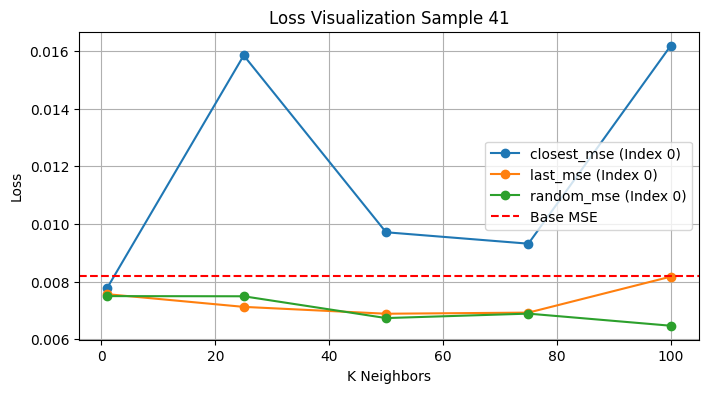

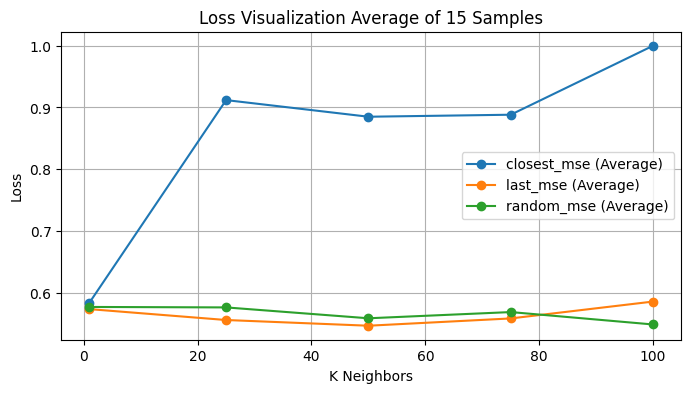

In [12]:
index_base = random_indices[0]
index_pos = random_indices.index(index_base)
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index_base)
base_error = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb)

max_knn = 100  # Set a maximum K value for visualization

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(mse_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title=f"Loss Visualization Sample {index_base}", ylabel="Loss", max_knn=max_knn)
visualize_results(mse_results, list_of_indices, average=True, normalize=True, title=f"Loss Visualization Average of {len(random_indices)} Samples", max_knn=max_knn)

In [13]:
plot_knn_distance_stats(knn_distances, subset='closest',k=78)

ValueError: Requested k=78 not available for 'closest_distances'. Available: [1, 25, 50, 75, 100]